# Forecasting taxi service data

**An aim of the research** — apply machine learning algorithms to predict the number of taxi orders for the next hour:
1. Analysis of time-series data
2. Comparison of data pre-processing technique between PySpark and Pandas libraries
3. Comparison of RMSE metrics of models built in PySpark and Scikit-learn
4. Building machine learning models:
  - Linear Regression
  - Decision Tree
  - Gradient Boosted Tree

**An initial data**

The dataframe is extracted from the file `taxi.csv`.

Since data pre-processing has not been carried out before, it is necessary to carry out Exploratory data analysis and Feature engineering.
 
The research is divided into three staps:
  1. Data overview
  2. Data pre-processing
  3. Machine learning models  

### Step 1. Data overview

In [1]:
# import libraries
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import window, Window
from pyspark.sql.functions import max as max_, min as min_
from pyspark.sql.functions import percent_rank, col, asc, desc, lit, lag, avg, signum 
from pyspark.sql.functions import unix_timestamp, from_unixtime, month, dayofmonth, dayofweek, hour
from pyspark.sql.types import StructType, StructField, LongType, DateType, IntegerType
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.ml.regression import LinearRegression as LinearRegressionSpark
from pyspark.ml.regression import DecisionTreeRegressor as DecisionTreeRegressorSpark
from pyspark.ml.regression import GBTRegressor as GBTRegressorSpark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinearRegressionSklearn
from sklearn.tree import DecisionTreeRegressor as DecisionTreeRegressorSklearn
from sklearn.ensemble import GradientBoostingRegressor as GradientBoostingRegressorSklearn
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

In [2]:
# set global parameters 
pd.set_option('precision', 2)
warnings.filterwarnings('ignore')

In [3]:
# define path to directory
path1 = '/datasets/taxi.csv'
path2 = 'C:/YandexPracticumProjects/Project_12_TaxiBooking_ML/taxi.csv'

#### PySpark

In [4]:
# initialize spark session
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

In [5]:
# read 'taxi.csv' in pyspark environment 
try:
    df_sp = spark.read.csv(path1)
    df_sp = spark.read.option('header', True).option('inferSchema', True).csv(path1)
except:  
    df_sp = spark.read.csv(path2)
    df_sp = spark.read.option('header', True).option('inferSchema', True).csv(path2)

In [6]:
# type of data
type(df_sp)

pyspark.sql.dataframe.DataFrame

In [7]:
# show 7 rows
df_sp.show(7)

+-------------------+----------+
|           datetime|num_orders|
+-------------------+----------+
|2018-03-01 00:00:00|         9|
|2018-03-01 00:10:00|        14|
|2018-03-01 00:20:00|        28|
|2018-03-01 00:30:00|        20|
|2018-03-01 00:40:00|        32|
|2018-03-01 00:50:00|        21|
|2018-03-01 01:00:00|         7|
+-------------------+----------+
only showing top 7 rows



#### Pandas

In [8]:
# read 'taxi.csv' in pyspark environment
try:
    df_pd = pd.read_csv(path1, index_col=[0], parse_dates=[0])
except:  
    df_pd = pd.read_csv(path2, index_col=[0], parse_dates=[0])

In [9]:
# type of data
type(df_pd)

pandas.core.frame.DataFrame

In [10]:
# check for monotonic increasing series 
df_pd.index.is_monotonic

True

In [11]:
# show 7 rows
display(df_pd.head(7))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


### Step 2. Data pre-processing

### 2.1 Resampling

#### PySpark

In [12]:
# convert hour and day to sec
hour_period = 60 * 60
day_period = 60 * 60 * 24

In [13]:
# function for aggregating data to arbitrary time intervals
def resample(column, agg_interval, time_format='yyyy-MM-dd HH:mm:ss'):
    if type(column) == str:
        column = F.col(column)

    # convert the timestamp to unix timestamp format
    col_ut =  F.unix_timestamp(column, format=time_format)

    # divide the time into discrete intervals, by rounding
    col_ut_agg =  F.floor(col_ut / agg_interval) * agg_interval  

    # convert to and return timestamp
    return F.from_unixtime(col_ut_agg)

In [14]:
# resample data by days
df_temp_sp = df_sp.withColumn('dt_resampled', resample(df_sp.datetime, agg_interval=day_period))

In [15]:
# resample data by hours
df_sp = df_sp.withColumn('dt_resampled', resample(df_sp.datetime, agg_interval=hour_period))
df_sp.show(7)

+-------------------+----------+-------------------+
|           datetime|num_orders|       dt_resampled|
+-------------------+----------+-------------------+
|2018-03-01 00:00:00|         9|2018-03-01 00:00:00|
|2018-03-01 00:10:00|        14|2018-03-01 00:00:00|
|2018-03-01 00:20:00|        28|2018-03-01 00:00:00|
|2018-03-01 00:30:00|        20|2018-03-01 00:00:00|
|2018-03-01 00:40:00|        32|2018-03-01 00:00:00|
|2018-03-01 00:50:00|        21|2018-03-01 00:00:00|
|2018-03-01 01:00:00|         7|2018-03-01 01:00:00|
+-------------------+----------+-------------------+
only showing top 7 rows



In [16]:
# group by resampled datetime
df_sp = df_sp.groupBy('dt_resampled')\
             .sum('num_orders')\
             .sort(asc('dt_resampled'))\
             .withColumnRenamed('sum(num_orders)', 'orders')

In [17]:
# remove unnecessary strings
df_sp = df_sp.filter(df_sp.dt_resampled != '2018-02-28')
df_sp.show(7)

+-------------------+------+
|       dt_resampled|orders|
+-------------------+------+
|2018-03-01 00:00:00|   124|
|2018-03-01 01:00:00|    85|
|2018-03-01 02:00:00|    71|
|2018-03-01 03:00:00|    66|
|2018-03-01 04:00:00|    43|
|2018-03-01 05:00:00|     6|
|2018-03-01 06:00:00|    12|
+-------------------+------+
only showing top 7 rows



#### Pandas

In [18]:
# resample data by days
df_temp_pd = df_pd.resample('1D').sum()

In [19]:
# resample data by hours
df_pd = df_pd.resample('1H').sum()
display(df_pd.head(7))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12


Resampling allows for changing (reducing) the frequency of time series for data analysis and further building machine learning models. As a result, the time-step is changed from minutes to hours, while the aggrigation function is applied to sum the targets (number of taxi orders) in accordance with the frequency of fluctuations.

### 2.2 Trend and seasonality

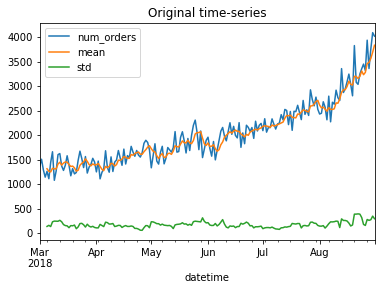

In [20]:
# plot original time-series
df_temp_pd['mean'] = df_temp_pd['num_orders'].rolling(5).mean()
df_temp_pd['std'] = df_temp_pd['num_orders'].rolling(5).std()
df_temp_pd.plot(title='Original time-series');

During a given period of time, the number of taxi orders gradually increases from about 1000 per day in March to 4000 at the end of August.

#### PySpark

In [21]:
# find trend in the univariate time series
class TrendGather:
    
    # initialize lag length and feature names
    def __init__(self):
        self.n_lags = 0 
        self.feature_names = []
        
    # set window-size over which trend is determined
    def set_lag_length(self, n_lags):
        self.n_lags = n_lags
        return self
    
    # sets time-series column for which trend is to be de
    def set_input_col(self, col_name):
        self.col_name = col_name
        return self
    
    # transform time-series column and create column with values +1 or -1 
    # if current value > time-lagged value then column-value = +1.0
    # if current value < time-lagged value then column-value = -1.0
    def transform(self, df):
        df = df.withColumn('series', lit('univariate'))       
        mywindow = Window.orderBy('series')
        for i in range(self.n_lags):
            sign_str = 'lag_' + str(i + 1) + '_trend'
            df = df.withColumn(
                sign_str, signum(
                    (df[self.col_name] - lag(df[self.col_name], i + 1).over(mywindow))
                )
            )
            self.feature_names.append(sign_str)
        df = df.drop('series')
        return df
    
    # return name of feature generted by transform method
    def get_feature_names(self):
        return self.feature_names

In [22]:
# generate trend values
tg = TrendGather().set_lag_length(1).set_input_col('orders')
df_trend_sp = tg.transform(df_sp)

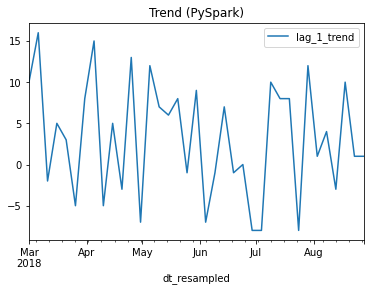

In [23]:
# plot trend
df_trend_sp_pd = df_trend_sp.toPandas()
df_trend_sp_pd['dt_resampled'] = pd.to_datetime(df_trend_sp_pd['dt_resampled'])
df_trend_sp_pd = df_trend_sp_pd.set_index('dt_resampled').drop(['orders'], axis=1)
df_trend_sp_pd = df_trend_sp_pd.resample('5D').sum()
df_trend_sp_pd.plot(title='Trend (PySpark)');

#### Pandas

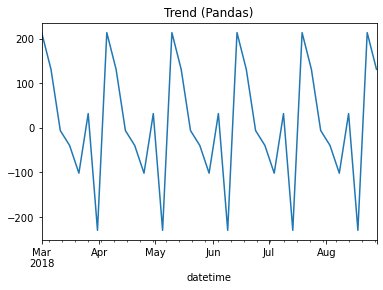

In [24]:
# plot trend
df_trend1_pd = df_pd['num_orders'].shift(1).resample('5D').sum()
df_trend2_pd = seasonal_decompose(df_trend1_pd)
df_trend2_pd.seasonal.plot(title='Trend (Pandas)');

In [ ]:
# # plot taxi booking during a day
# fig = plt.figure()
# counter = 24
# while counter < df_trend2_pd.seasonal.shape[0]:
#     plt.plot(df_trend2_pd.seasonal[counter-24:counter].reset_index(drop=True), figure=fig)
#     plt.title('Taxi booking during a day')
#     counter += 24

The graphs show that taxi bookings reach a peak in the middle of the month from May to July, and in April and August around the beginning of the month. 

### 2.3 Stationarity

#### PySpark

In [26]:
# function of time-differencing for making the series stationary
def difference(df, inputCol, outputCol):
    # perform first-order differencing
    # '0' means 'current row', while '-1' means the row before the current row
    lag1Window = window.Window.rowsBetween(-1, 0)
    df_diff = df.withColumn(outputCol, df[inputCol] - F.first(df[inputCol]).over(lag1Window))
    return df_diff

In [27]:
# group by resampled datetime
df_temp_sp = df_temp_sp.groupBy('dt_resampled')\
                       .sum('num_orders')\
                       .sort(asc('dt_resampled'))\
                       .withColumnRenamed('sum(num_orders)', 'orders')

In [28]:
# performe time-differencing (1st order)
df_diff_sp = difference(df_temp_sp, 'orders', 'orders_diff')

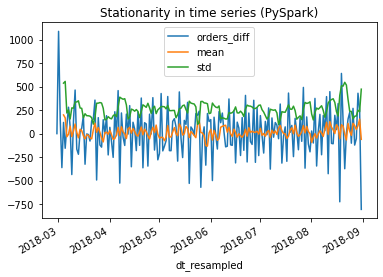

In [29]:
# plot number of orders, their mean and std 
df_diff_sp_pd = df_diff_sp.toPandas()
df_diff_sp_pd['dt_resampled'] = pd.to_datetime(df_diff_sp_pd['dt_resampled'])
df_diff_sp_pd = df_diff_sp_pd.set_index('dt_resampled').drop(['orders'], axis=1)
df_diff_sp_pd['mean'] = df_diff_sp_pd['orders_diff'].rolling(5).mean()
df_diff_sp_pd['std'] = df_diff_sp_pd['orders_diff'].rolling(5).std()
df_diff_sp_pd.plot(title='Stationarity in time series (PySpark)');

#### Pandas

In [30]:
# performe time-differencing (1st order)
df_diff_pd = df_temp_pd - df_temp_pd.shift()
df_diff_pd['mean'] = df_diff_pd['num_orders'].rolling(5).mean()
df_diff_pd['std'] = df_diff_pd['num_orders'].rolling(5).std()

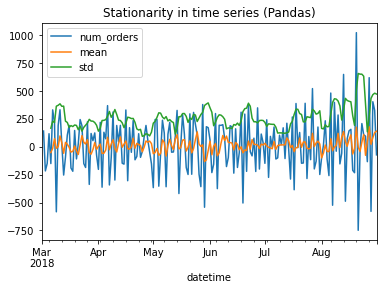

In [31]:
# plot number of orders, their mean and std 
df_diff_pd.plot(title='Stationarity in time series (Pandas)');

First time derivative is taken for time series analysis by a function developed in PySpark using the standard Window function, and a built-in function in Pandas. Next, graphs are built on the transformed data, which show that the fluctuations propagate along the x-axis and, therefore, the target does not depend on time (difference-stationary).

### 2.4 New features

#### PySpark

In [32]:
# obtain time-lagged values of a given univariate time-series
class LagGather:
    
    # initialize lag length and feature names
    def __init__(self):
        self.n_lags = 0
        self.feature_names = []

    # set lag length of previous time-step 
    def set_lag_length(self, n_lags):  
        self.n_lags = n_lags
        return self

    # specify column on time-lagging operation
    def set_input_col(self, col_name): 
        self.col_name = col_name
        return self

    # return column whose values are time-lagged
    def transform(self, df):              
        df = df.withColumn('series', lit('univariate'))
        mywindow = Window.orderBy('series')
        for i in range(self.n_lags):
            lag_str = 'lag_' + str(i + 1)
            df = df.withColumn(lag_str, lag(df[self.col_name], i + 1).over(mywindow))
            self.feature_names.append(lag_str)
        df = df.drop('series')
        return df

    # return name of newly created column with time-lagged values
    def get_feature_names(self):       
        return self.feature_names

In [33]:
# generate time-lagged values
lg = LagGather().set_input_col('orders').set_lag_length(10)
df_trans1_sp = lg.transform(df_sp)

In [34]:
# new feature column names
lag_cols = df_trans1_sp.columns[2:]
lag_cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10']

In [35]:
# time-lagged data values
df_trans1_sp.show(15)

+-------------------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|       dt_resampled|orders|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|lag_7|lag_8|lag_9|lag_10|
+-------------------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|2018-03-01 00:00:00|   124| null| null| null| null| null| null| null| null| null|  null|
|2018-03-01 01:00:00|    85|  124| null| null| null| null| null| null| null| null|  null|
|2018-03-01 02:00:00|    71|   85|  124| null| null| null| null| null| null| null|  null|
|2018-03-01 03:00:00|    66|   71|   85|  124| null| null| null| null| null| null|  null|
|2018-03-01 04:00:00|    43|   66|   71|   85|  124| null| null| null| null| null|  null|
|2018-03-01 05:00:00|     6|   43|   66|   71|   85|  124| null| null| null| null|  null|
|2018-03-01 06:00:00|    12|    6|   43|   66|   71|   85|  124| null| null| null|  null|
|2018-03-01 07:00:00|    15|   12|    6|   43|   66|   71|   85|  124| null| null|  null|
|2018-03-0

In [36]:
# generate columns witn values of moving average over a window
class MovingAverage:
    
    # initialize lag length and feature names
    def __init__(self):
        self.n_lags = 0
        self.feature_names = []
        
    # set lag length of previous time-step 
    def set_lag_length(self, n_lags):
        self.n_lags = n_lags
        return self
    
    # specify column on time-lagging operation
    def set_input_col(self, col_names):
        self.col_names = col_names
        return self
    
    # generate column with values that are moving averages over window
    def transform(self, df):
        for idx, col in enumerate(self.col_names):
            mywindow = Window.rowsBetween(-self.n_lags, 0)
            moving_avg = self.col_names[idx] + '_avg'
            df = df.withColumn(moving_avg, avg(df[col]).over(mywindow).cast(IntegerType()))
            self.feature_names.append(moving_avg)
        return df 
    
    # return name of newly created column with moving average values
    def get_feature_names(self):
        return self.feature_names

In [37]:
# generate moving average values on time-lagged ones
ma = MovingAverage().set_input_col([lag_cols[-1]]).set_lag_length(10)
df_trans2_sp = ma.transform(df_trans1_sp)

In [38]:
# function for extracting timestamp
def extract_timestamp(df, col):
    df = df.withColumn('month', month(df[col]))\
           .withColumn('monthday', dayofmonth(df[col]))\
           .withColumn('weekday', dayofweek(df[col]))\
           .withColumn('hour', hour(df[col]))
    return df

In [39]:
# extract timestamp and show newly generated features
df_trans2_sp = extract_timestamp(df_trans2_sp, 'dt_resampled')
df_trans2_sp.show(15)

+-------------------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+----------+-----+--------+-------+----+
|       dt_resampled|orders|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|lag_7|lag_8|lag_9|lag_10|lag_10_avg|month|monthday|weekday|hour|
+-------------------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+----------+-----+--------+-------+----+
|2018-03-01 00:00:00|   124| null| null| null| null| null| null| null| null| null|  null|      null|    3|       1|      5|   0|
|2018-03-01 01:00:00|    85|  124| null| null| null| null| null| null| null| null|  null|      null|    3|       1|      5|   1|
|2018-03-01 02:00:00|    71|   85|  124| null| null| null| null| null| null| null|  null|      null|    3|       1|      5|   2|
|2018-03-01 03:00:00|    66|   71|   85|  124| null| null| null| null| null| null|  null|      null|    3|       1|      5|   3|
|2018-03-01 04:00:00|    43|   66|   71|   85|  124| null| null| null| null| null|  null|      nu

#### Pandas

In [40]:
# function for making features
def make_features(df, max_lag, moving_avg_size):
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['lag_{}_avg'.format(max_lag)] = df['num_orders'].shift().rolling(moving_avg_size).mean()

    df['month'] = df.index.month
    df['monthday'] = df.index.day
    df['weekday'] = df.index.dayofweek
    df['hour'] = df.index.hour

    return df

In [41]:
# call function and plot dataframe    
df_trans1_pd = make_features(df_pd, 10, 10)
display(df_trans1_pd.head(15))

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_10_avg,month,monthday,weekday,hour
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3,0
2018-03-01 01:00:00,85,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3,1
2018-03-01 02:00:00,71,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3,2
2018-03-01 03:00:00,66,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3,3
2018-03-01 04:00:00,43,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3,4
2018-03-01 05:00:00,6,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3,5
2018-03-01 06:00:00,12,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,3,1,3,6
2018-03-01 07:00:00,15,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,3,1,3,7
2018-03-01 08:00:00,34,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,3,1,3,8


To make predictions using a time-series machine learning model, the Feature Engineering method is applied to generate new model parameters from existing data. To do this, the values of the target attribute are shifted from 1 to 10 time-steps, the moving average attribute with a dimension of 10 is added, and the month/day/hour is extracted from the recorded data on taxi orders.

### Step 3. Machine learning models

### 3.1 Dataset for ML

#### PySpark

In [42]:
# rename target 'orders' to 'label
df_trans2_sp = df_trans2_sp.withColumnRenamed('orders', 'label')

In [43]:
# drop rows with null values
df_trans3_sp = df_trans2_sp.na.drop()

In [44]:
# split data into train and test sets by 90/10
df_trans3_sp = df_trans3_sp.withColumn(
    'rank', percent_rank().over(Window.partitionBy().orderBy('dt_resampled'))
)
df_train_sp = df_trans3_sp.where('rank <= .9').drop('rank')
df_test_sp = df_trans3_sp.where('rank > .9').drop('rank')

In [45]:
# print out the last row in train and first row in test
print(df_train_sp.tail(1))
print(df_test_sp.take(1))

[Row(dt_resampled='2018-08-13 14:00:00', label=102, lag_1=119, lag_2=92, lag_3=144, lag_4=156, lag_5=137, lag_6=91, lag_7=39, lag_8=66, lag_9=83, lag_10=143, lag_10_avg=170, month=8, monthday=13, weekday=2, hour=14)]
[Row(dt_resampled='2018-08-13 15:00:00', label=175, lag_1=102, lag_2=119, lag_3=92, lag_4=144, lag_5=156, lag_6=137, lag_7=91, lag_8=39, lag_9=66, lag_10=83, lag_10_avg=171, month=8, monthday=13, weekday=2, hour=15)]


In [46]:
# assemble and vectorize features
cols_assy = lag_cols + ['month', 'monthday', 'weekday', 'hour']
assy = VectorAssembler(inputCols=cols_assy, outputCol='features')
data_train_sp = assy.transform(df_train_sp)
data_test_sp = assy.transform(df_test_sp)
data_test_sp.printSchema()

root
 |-- dt_resampled: string (nullable = true)
 |-- label: long (nullable = true)
 |-- lag_1: long (nullable = true)
 |-- lag_2: long (nullable = true)
 |-- lag_3: long (nullable = true)
 |-- lag_4: long (nullable = true)
 |-- lag_5: long (nullable = true)
 |-- lag_6: long (nullable = true)
 |-- lag_7: long (nullable = true)
 |-- lag_8: long (nullable = true)
 |-- lag_9: long (nullable = true)
 |-- lag_10: long (nullable = true)
 |-- lag_10_avg: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- monthday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- features: vector (nullable = true)



#### Pandas

In [47]:
# drop rows with NaN values
df_trans2_pd = df_trans1_pd.dropna()

In [48]:
# split data into train and test sets by 90/10
df_train_pd, df_test_pd = train_test_split(df_trans2_pd, shuffle=False, test_size=0.1)

In [49]:
# print out the last row in train and first row in test
display(df_train_pd.tail(1))
display(df_test_pd.head(1))

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_10_avg,month,monthday,weekday,hour
datetime,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,107.0,8,13,0,14


,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_10_avg,month,monthday,weekday,hour
datetime,,,,,,,,,,,,,,,,
2018-08-13 15:00:00,175,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,102.9,8,13,0,15


In [50]:
# create features and target
X_train_pd = df_train_pd.drop(['num_orders'], axis=1)
y_train_pd = df_train_pd['num_orders']

X_test_pd = df_test_pd.drop(['num_orders'], axis=1) 
y_test_pd = df_test_pd['num_orders']

### 3.2 ML models

### 3.2.1 Linear Regression model

#### PySpark

In [51]:
# create linear regression model to data train
lr_sp = LinearRegressionSpark(
    featuresCol='features', 
    labelCol='label', 
    predictionCol='prediction', 
    maxIter=100,
    fitIntercept=True, 
    standardization=False,
    solver='auto',
    aggregationDepth=2,
    loss='squaredError'
)

In [52]:
# fit model to data train
lr_start1_sp = time.time()
lr_model_sp = lr_sp.fit(data_train_sp)
lr_end1_sp = time.time()
lr_time1_sp = lr_end1_sp - lr_start1_sp
print('Time elapsed for model fit in Linear Regression: {} sec'.format(lr_time1_sp))

Time elapsed for model fit in Linear Regression: 19.285786867141724 sec


In [53]:
# make prediction on data test
lr_start2_sp = time.time()
lr_pred_sp = lr_model_sp.transform(data_test_sp)
lr_end2_sp = time.time()
lr_time2_sp = lr_end2_sp - lr_start2_sp
print('Time elapsed for prediction in Linear Regression: {} sec'.format(lr_time2_sp))

Time elapsed for prediction in Linear Regression: 0.06478357315063477 sec


In [54]:
# prediction and label
lr_pred_sp.select('prediction', 'label', 'features').orderBy('dt_resampled').show(5)

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|101.84809063634592|  175|[102.0,119.0,92.0...|
|140.32401242468214|  144|[175.0,102.0,119....|
|132.44429694292518|  152|[144.0,175.0,102....|
|127.44375549272716|  104|[152.0,144.0,175....|
| 98.51747945261434|   91|[104.0,152.0,144....|
+------------------+-----+--------------------+
only showing top 5 rows



In [55]:
# calculate RMSE
lr_rmse_sp = RegressionEvaluator(predictionCol='prediction', metricName='rmse')
lr_rmse_print_sp = lr_rmse_sp.evaluate(lr_pred_sp)
print('Root Mean Squared Error (RMSE) in Linear Regression: %g' % lr_rmse_print_sp)

Root Mean Squared Error (RMSE) in Linear Regression: 53.6317


#### Scikit-learn

In [56]:
# create linear regression model
lr_sk = LinearRegressionSklearn(
    fit_intercept=True, 
    normalize='deprecated', 
    copy_X=True, 
    positive=False
)

In [57]:
# fit model to data train
lr_start1_sk = time.time()
lr_model_sk = lr_sk.fit(X_train_pd, y_train_pd)
lr_end1_sk = time.time()
lr_time1_sk = lr_end1_sk - lr_start1_sk
print('Time elapsed for model fit in Linear Regression: {} sec'.format(lr_time1_sk))

Time elapsed for model fit in Linear Regression: 0.010918140411376953 sec


In [58]:
# make prediction on data test
lr_start2_sk = time.time()
lr_pred_sk = lr_model_sk.predict(X_test_pd)
lr_end2_sk = time.time()
lr_time2_sk = lr_end2_sk - lr_start2_sk
print('Time elapsed for prediction in Linear Regression: {} sec'.format(lr_time2_sk))

Time elapsed for prediction in Linear Regression: 0.004114866256713867 sec


In [59]:
# prediction and label
lr_result_sk = pd.DataFrame({'prediction': lr_pred_sk.squeeze(), 'label': y_test_pd.squeeze()})
display(lr_result_sk.head(5))

,prediction,label
datetime,,
2018-08-13 15:00:00,102.91,175
2018-08-13 16:00:00,141.57,144
2018-08-13 17:00:00,133.78,152
2018-08-13 18:00:00,129.07,104
2018-08-13 19:00:00,100.22,91


In [60]:
# calculate RMSE
lr_rmse_print_sk = mean_squared_error(y_test_pd, lr_pred_sk, squared=False)
print('Root Mean Squared Error (RMSE) in Linear Regression: %g' % lr_rmse_print_sk)

Root Mean Squared Error (RMSE) in Linear Regression: 53.5157


### 3.2.2 Decision Tree Regression model

#### PySpark

In [61]:
# create Decision Tree regression model 
dt_sp = DecisionTreeRegressorSpark(
    featuresCol='features', 
    labelCol='label', 
    predictionCol='prediction', 
    maxDepth=7, 
    maxBins=32, 
    minInstancesPerNode=1, 
    minInfoGain=0.0, 
    checkpointInterval=10, 
    impurity='variance', 
    seed=777, 
    minWeightFractionPerNode=0.0
)

In [62]:
# fit model to data train
dt_start1_sp = time.time()
dt_model_sp = dt_sp.fit(data_train_sp)
dt_end1_sp = time.time()
dt_time1_sp = dt_end1_sp - dt_start1_sp
print('Time elapsed for fit in Decision Tree: {} sec'.format(dt_time1_sp))

Time elapsed for fit in Decision Tree: 13.185607433319092 sec


In [63]:
# make prediction on data test
dt_start2_sp = time.time()
dt_pred_sp = dt_model_sp.transform(data_test_sp)
dt_end2_sp = time.time()
dt_time2_sp = dt_end2_sp - dt_start2_sp
print('Time elapsed for prediction in Decision Tree: {} sec'.format(dt_time2_sp))

Time elapsed for prediction in Decision Tree: 0.07626485824584961 sec


In [64]:
# view result with column selection
dt_pred_sp.select('prediction', 'label', 'features').orderBy('dt_resampled').show(5)

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 92.28571428571429|  175|[102.0,119.0,92.0...|
|            175.75|  144|[175.0,102.0,119....|
|124.74324324324324|  152|[144.0,175.0,102....|
|124.74324324324324|  104|[152.0,144.0,175....|
| 92.28571428571429|   91|[104.0,152.0,144....|
+------------------+-----+--------------------+
only showing top 5 rows



In [65]:
# calculate RMSE
dt_rmse_sp = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')
dt_rmse_print_sp = dt_rmse_sp.evaluate(dt_pred_sp)
print('Root Mean Squared Error (RMSE) in Decision Tree: %g' % dt_rmse_print_sp)

Root Mean Squared Error (RMSE) in Decision Tree: 49.8547


#### Scikit-learn

In [66]:
# create Decision Tree regression model
dt_sk = DecisionTreeRegressorSklearn(
    criterion='friedman_mse', 
    splitter='best', 
    max_depth=7, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=777, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    ccp_alpha=0.0
)

In [67]:
# fit model to data train
dt_start1_sk = time.time()
dt_model_sk = dt_sk.fit(X_train_pd, y_train_pd)
dt_end1_sk = time.time()
dt_time1_sk = dt_end1_sk - dt_start1_sk
print('Time elapsed for model fit in Decision Tree: {} sec'.format(dt_time1_sk))

Time elapsed for model fit in Decision Tree: 0.03726339340209961 sec


In [68]:
# make prediction on data test
dt_start2_sk = time.time()
dt_pred_sk = dt_model_sk.predict(X_test_pd)
dt_end2_sk = time.time()
dt_time2_sk = dt_end2_sk - dt_start2_sk
print('Time elapsed for prediction in Decision Tree: {} sec'.format(dt_time2_sk))

Time elapsed for prediction in Decision Tree: 0.003125905990600586 sec


In [69]:
# prediction and label
dt_result_sk = pd.DataFrame({'prediction': dt_pred_sk.squeeze(), 'label': y_test_pd.squeeze()})
display(dt_result_sk.head(5))

,prediction,label
datetime,,
2018-08-13 15:00:00,95.96,175
2018-08-13 16:00:00,160.50,144
2018-08-13 17:00:00,119.39,152
2018-08-13 18:00:00,119.39,104
2018-08-13 19:00:00,95.96,91


In [70]:
# calculate RMSE
dt_rmse_print_sk = mean_squared_error(y_test_pd, dt_pred_sk, squared=False)
print('Root Mean Squared Error (RMSE) in Decision Tree: %g' % dt_rmse_print_sk)

Root Mean Squared Error (RMSE) in Decision Tree: 50.6199


#### 3.2.4 Gradient Boosted Tree Regression model

#### PySpark

In [71]:
# create Gradient Boosted Tree regression model
gbt_sp = GBTRegressorSpark(
    featuresCol='features', 
    labelCol='label',
    predictionCol='prediction',
    maxDepth=7,
    maxBins=32,
    minInstancesPerNode=1,
    minInfoGain=0.0,
    subsamplingRate=1.0,
    checkpointInterval=10,
    lossType='squared',
    maxIter=15,
    stepSize=0.1,
    seed=777,
    featureSubsetStrategy='all',
    validationTol=0.1,
    minWeightFractionPerNode=0.0
)

In [72]:
# fit model to data train
gbt_start1_sp = time.time()
gbt_model_sp = gbt_sp.fit(data_train_sp)
gbt_end1_sp = time.time()
gbt_time1_sp = gbt_end1_sp - gbt_start1_sp
print('Time elapsed for fit in Gradient Boosted Tree: {} sec'.format(gbt_time1_sp))

Time elapsed for fit in Gradient Boosted Tree: 20.634271144866943 sec


In [73]:
# make prediction on data test
gbt_start2_sp = time.time()
gbt_pred_sp = gbt_model_sp.transform(data_test_sp)
gbt_end2_sp = time.time()
gbt_time2_sp = gbt_end2_sp - gbt_start2_sp
print('Time elapsed for prediction in Gradient Boosted Tree: {} sec'.format(gbt_time2_sp))

Time elapsed for prediction in Gradient Boosted Tree: 0.10597896575927734 sec


In [74]:
# view result of prediction, label, features
gbt_pred_sp.select('prediction', 'label', 'features').orderBy('dt_resampled').show(5)

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 98.68952548314049|  175|[102.0,119.0,92.0...|
| 205.7678361532029|  144|[175.0,102.0,119....|
| 158.1918473280271|  152|[144.0,175.0,102....|
|132.14402365881844|  104|[152.0,144.0,175....|
|105.39069874371876|   91|[104.0,152.0,144....|
+------------------+-----+--------------------+
only showing top 5 rows



In [75]:
# calculate RMSE
gbt_rmse_sp = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')
gbt_rmse_print_sp = gbt_rmse_sp.evaluate(gbt_pred_sp)
print('Root Mean Squared Error (RMSE) in Gradient Boosted Tree: %g' % gbt_rmse_print_sp)

Root Mean Squared Error (RMSE) in Gradient Boosted Tree: 45.3337


#### Scikit-learn

In [76]:
# create Gradient Boosted Tree regression model
gbt_sk = GradientBoostingRegressorSklearn(
    loss='huber', 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=1.0, 
    criterion='friedman_mse', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_depth=7, 
    min_impurity_decrease=0.0, 
    random_state=777, 
    alpha=0.9, 
    verbose=0, 
    max_leaf_nodes=None,
    warm_start=False, 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.01, 
    ccp_alpha=0.0
)

In [77]:
# fit model to data train
gbt_start1_sk = time.time()
gbt_model_sk = gbt_sk.fit(X_train_pd, y_train_pd)
gbt_end1_sk = time.time()
gbt_time1_sk = gbt_end1_sk - gbt_start1_sk
print('Time elapsed for fit in Gradient Boosted Tree: {} sec'.format(gbt_time1_sk))

Time elapsed for fit in Gradient Boosted Tree: 6.377146482467651 sec


In [78]:
# make prediction on data test
gbt_start2_sk = time.time()
gbt_pred_sk = gbt_model_sk.predict(X_test_pd)
gbt_end2_sk = time.time()
gbt_time2_sk = gbt_end2_sk - gbt_start2_sk
print('Time elapsed for prediction in Gradient Boosted Tree: {} sec'.format(gbt_time2_sk))

Time elapsed for prediction in Gradient Boosted Tree: 0.006988525390625 sec


In [79]:
# prediction and label
gbt_result_sk = pd.DataFrame({'prediction': gbt_pred_sk.squeeze(), 'label': y_test_pd.squeeze()})
display(gbt_result_sk.head(5))

,prediction,label
datetime,,
2018-08-13 15:00:00,101.39,175
2018-08-13 16:00:00,132.86,144
2018-08-13 17:00:00,123.08,152
2018-08-13 18:00:00,101.30,104
2018-08-13 19:00:00,104.63,91


In [80]:
# calculate RMSE
gbt_rmse_print_sk = mean_squared_error(y_test_pd, gbt_pred_sk, squared=False)
print('Root Mean Squared Error (RMSE) in Decision Tree: %g' % gbt_rmse_print_sk)

Root Mean Squared Error (RMSE) in Decision Tree: 43.4782


To select the optimal model in the time-series problem, three regression algorithms are applied: Linear Regression, Decision Tree, and Gradient Boosted Tree. All models are tested in two frameworks PySpark and Scikit-learn with similar hyperparameters for model verification and prediction accuracy assessment.

### Results

In [81]:
# results table
results = [['PySpark', lr_rmse_print_sp, dt_rmse_print_sp, gbt_rmse_print_sp],
           ['Sklearn', lr_rmse_print_sk, dt_rmse_print_sk, gbt_rmse_print_sk]]
columns = ['Framework', 'Linear Regression', 'Decision Tree', 'Gradient Boosted Tree']

results_table = pd.DataFrame(data=results, columns=columns)\
                  .style.set_caption('Root Mean Squared Error (RMSE)')
display(results_table)

,Framework,Linear Regression,Decision Tree,Gradient Boosted Tree
0,PySpark,53.63,49.85,45.33
1,Sklearn,53.52,50.62,43.48


### Conclusions

Additional parameters are generated from the existing data by applying attribute offsets and extracting the timestamp from the recorded datetime. As a result, 15 additional attributes are obtained, which are used to predict taxi orders.

The PySpark and Pandas libraries are used for data preprocessing and analysis. Pandas has the largest number of built-in functions, which allows for data transformation in a few lines of code. At the same time, PySpark gives more options when writing low-level code using object-oriented design.

A comparison of frameworks for machine learning models shows that when using similar hyperparameters in PySpark and Scikit-learn, it gives almost the same result, the difference in RMSE is from 0.1 to 1.8.

In accordance with the technical requirements the test data amounted to 10% of the total data. Also, the RMSE prediction accuracy metric for the test data should be no more than 48. The results showed that the Gradient Boosted Tree model (RMSE=43..45) corresponds to this criterion.